In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 1,
                 "param_name_str" : "t1t2",
                 "retrain_GP": 25,
                 "num_x_data": 5,
                 "outputscl": 1,
                 "bo_iter_tot": 50,
                 "num_val_pts": 20,
                 "lenscl": None}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [ ]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# df_best["Min Obj Act"].iloc[2]
# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Termination,Total Run Time,L2 Norm Theta
59,3,14,0.003746,1.0,0.000000,"[-1.5789473684210527, -1.368421052631579]",0.000153,3.281994e-04,"[0.9985516008616891, -1.0030059785759486]",0.000328,"[0.9985516008616891, -1.0030059785759486]",0.593470,1,A1,15,ei,8.902051,0.003337
129,2,9,-7.028668,1.0,0.000130,"[1.575060175342469, -0.7396830773010377]",-7.080302,-7.515319e+00,"[1.0073770998736085, -1.0001163508902067]",-7.515319,"[1.0073770998736085, -1.0001163508902067]",0.621456,1,B1,19,obj,11.807662,0.007378
225,1,26,0.000003,1.0,8.083592,"[0.9996226685930034, -0.9999474235278523]",0.000002,8.710532e-07,"[0.9997097498538293, -0.9999709960678841]",0.000001,"[0.9997097498538293, -0.9999709960678841]",7.352978,1,A2,27,obj,198.530406,0.000292
464,4,30,-12.557581,1.0,0.897919,"[0.9997033592532008, -0.9997399945414572]",-13.620512,-1.296081e+01,"[0.9997401591943246, -0.99977800995596]",-12.960807,"[0.9997401591943246, -0.99977800995596]",46.748978,1,B2,31,obj,1449.218322,0.000342
472,1,3,0.001770,1.0,0.000000,"[0.3157894736842106, -1.1578947368421053]",0.000119,6.561237e-04,"[0.9944551220724419, -0.9967976709690746]",0.000656,"[0.9944551220724419, -0.9967976709690746]",149.151654,1,C2,4,ei,596.606614,0.006403


In [ ]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

c0a3cb6952ed751101eef20c12ac00d0
bdf08fcf36dc8e4527ce5bdcba5e9000
d502b1f4d58f1712053d4e8789b8129d
f9bd07d635d1539774bebe4d7a7ec31b
9df917a75cded9789e20fd977a688f5d


C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_20748\749023213.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_20748\749023213.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_20748\749023213.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
C:\Users\mcarlozo\AppData\Local\Temp\ipykernel_20748\749023213.py:13: FutureWarning: Callin

In [ ]:
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
for i in range(len(job_list_best)): 
    #define file path
    file_path = "workspace/" + str(job_list_best[i].id) + "/BO_Results.gz"

    #Open the file and get the dataframe
    with gzip.open(file_path, 'rb') as fileObj:
        results = pickle.load(fileObj)   
    fileObj.close()

    #Print ei results
    print(results[run_num_list[i-1]].why_term)

c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionW

ei
obj


c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionW

obj


c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionW

obj


c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\mcarlozo\AppData\Local\anaconda3\envs\Toy_Problem_env\Lib\site-packages\sklearn\base.py:348: InconsistentVersionW

IndexError: list index out of range

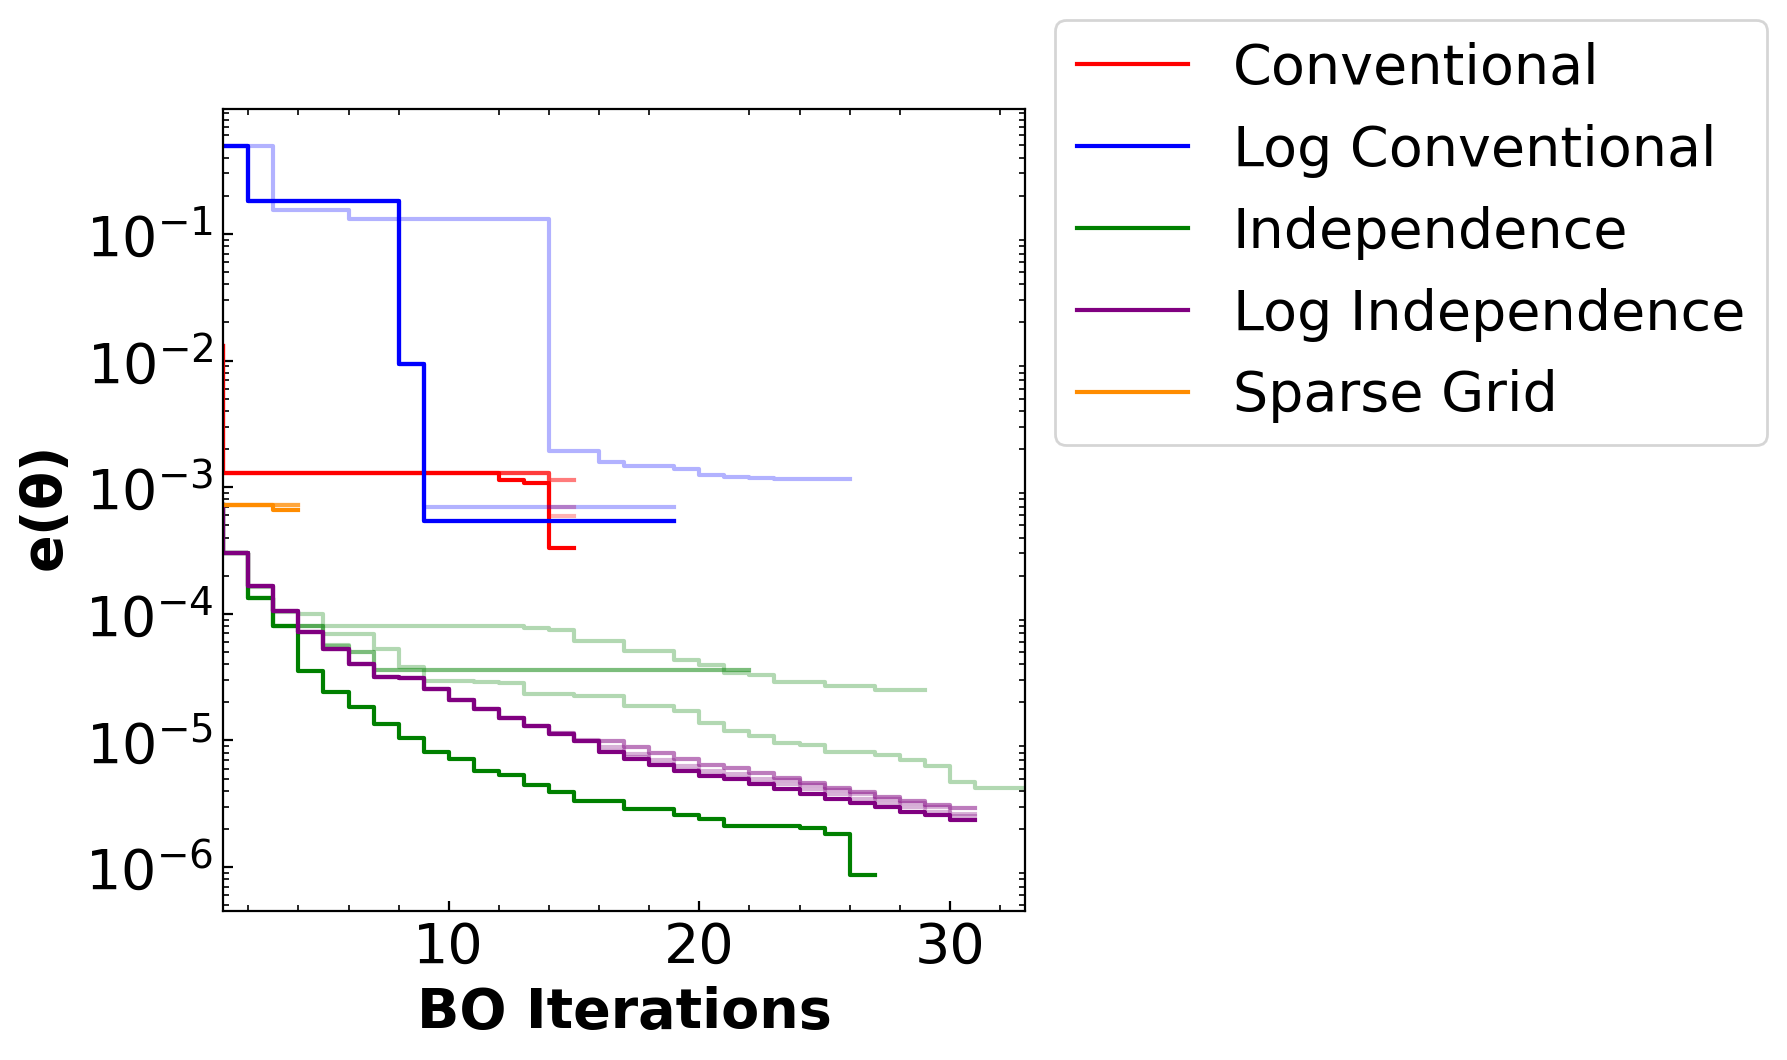

In [5]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2"]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["Min SSE"]
string_for_df_theta = ["Min Obj Cum."]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = r"$\mathbf{e(\theta)}$"
# title = "Min SSE Values"
title = None
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_method_sse_one_plot(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

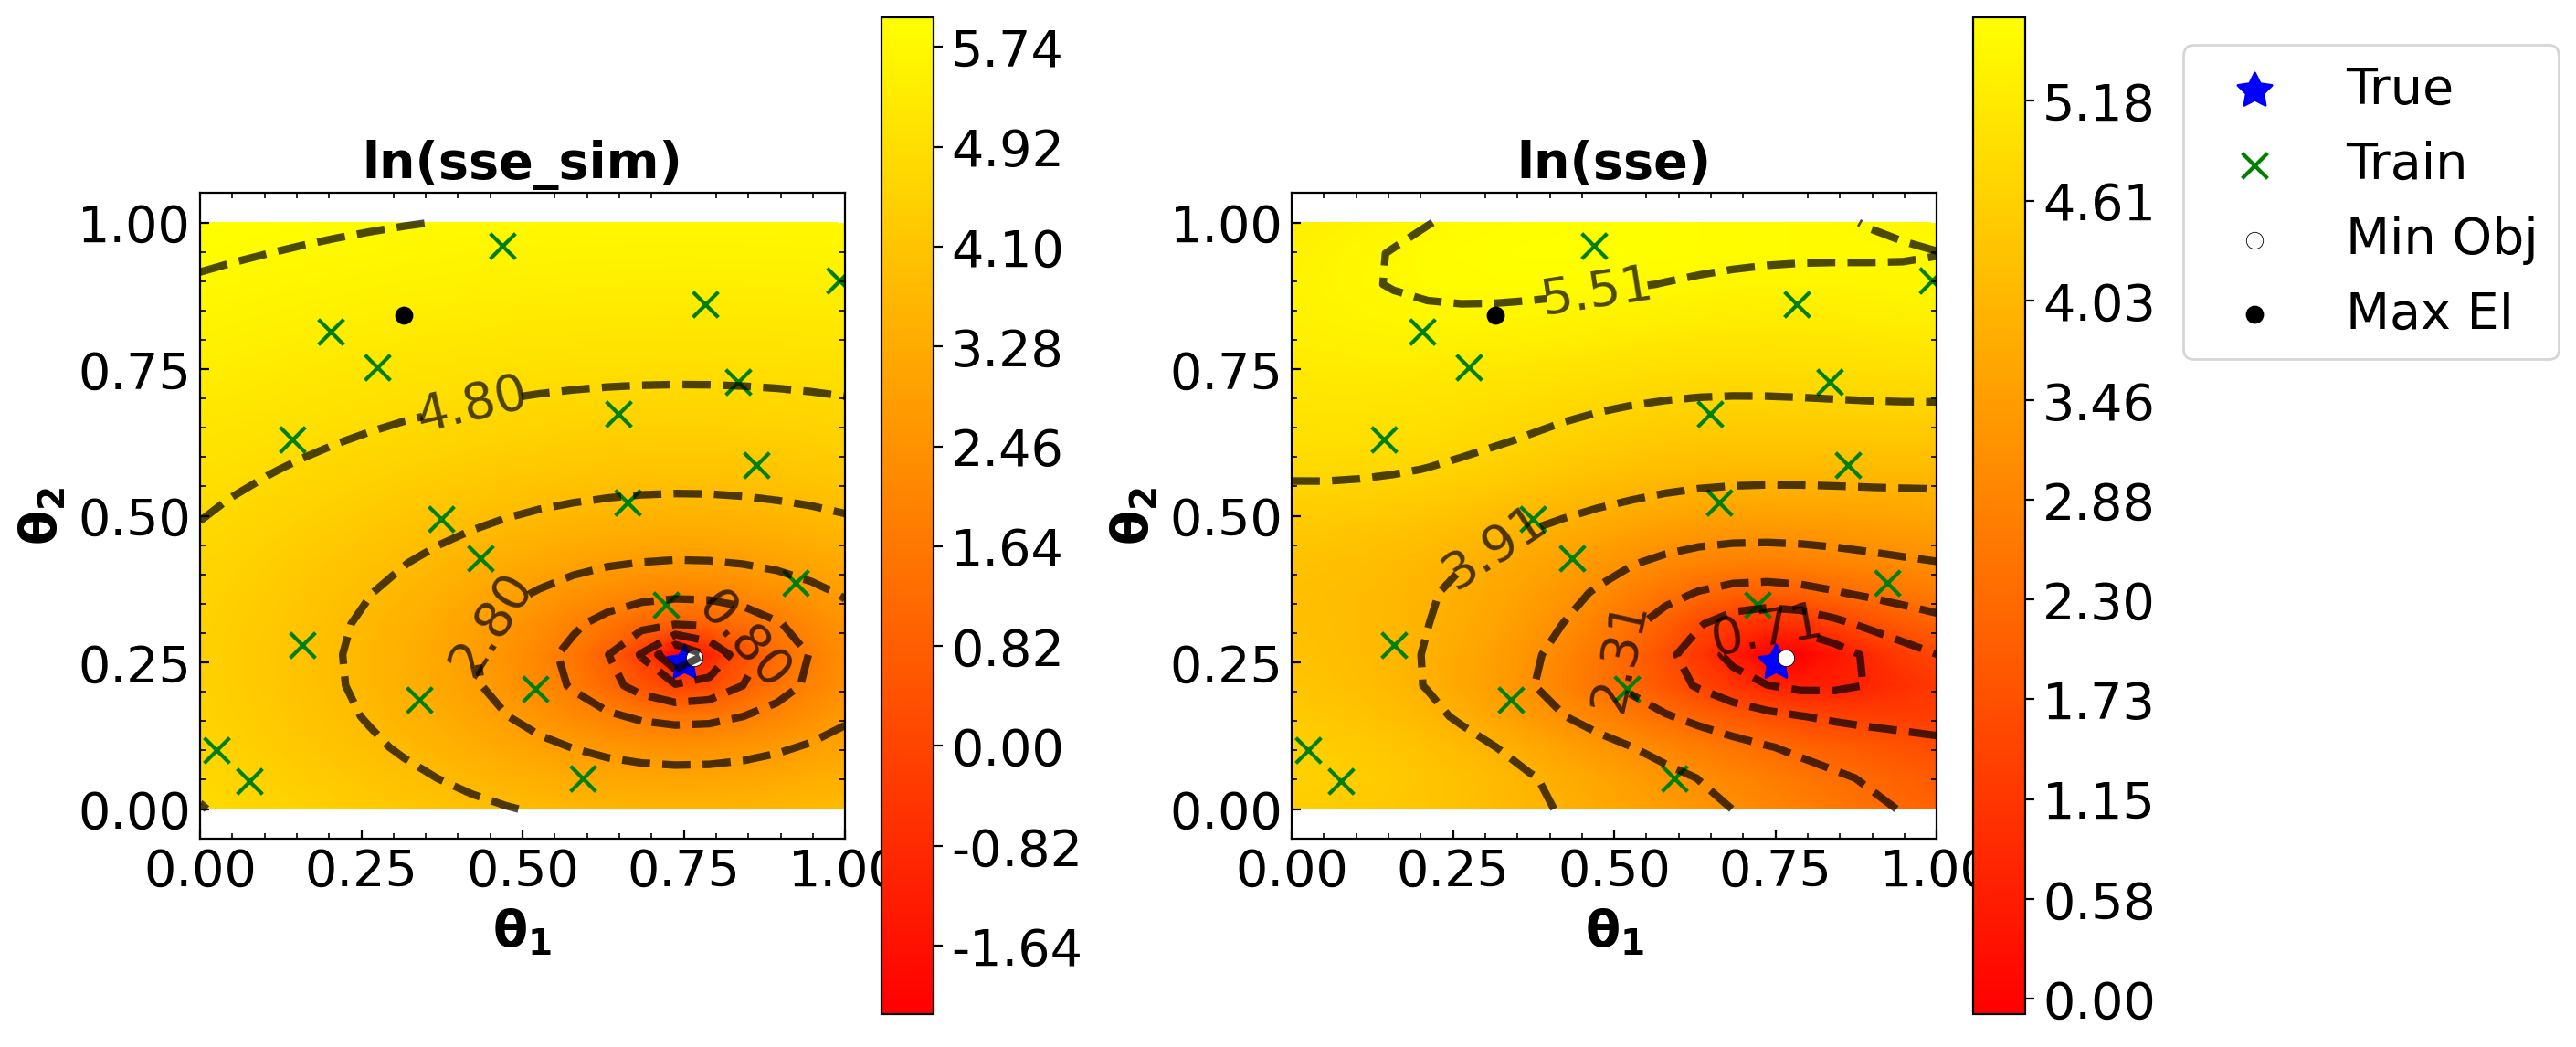

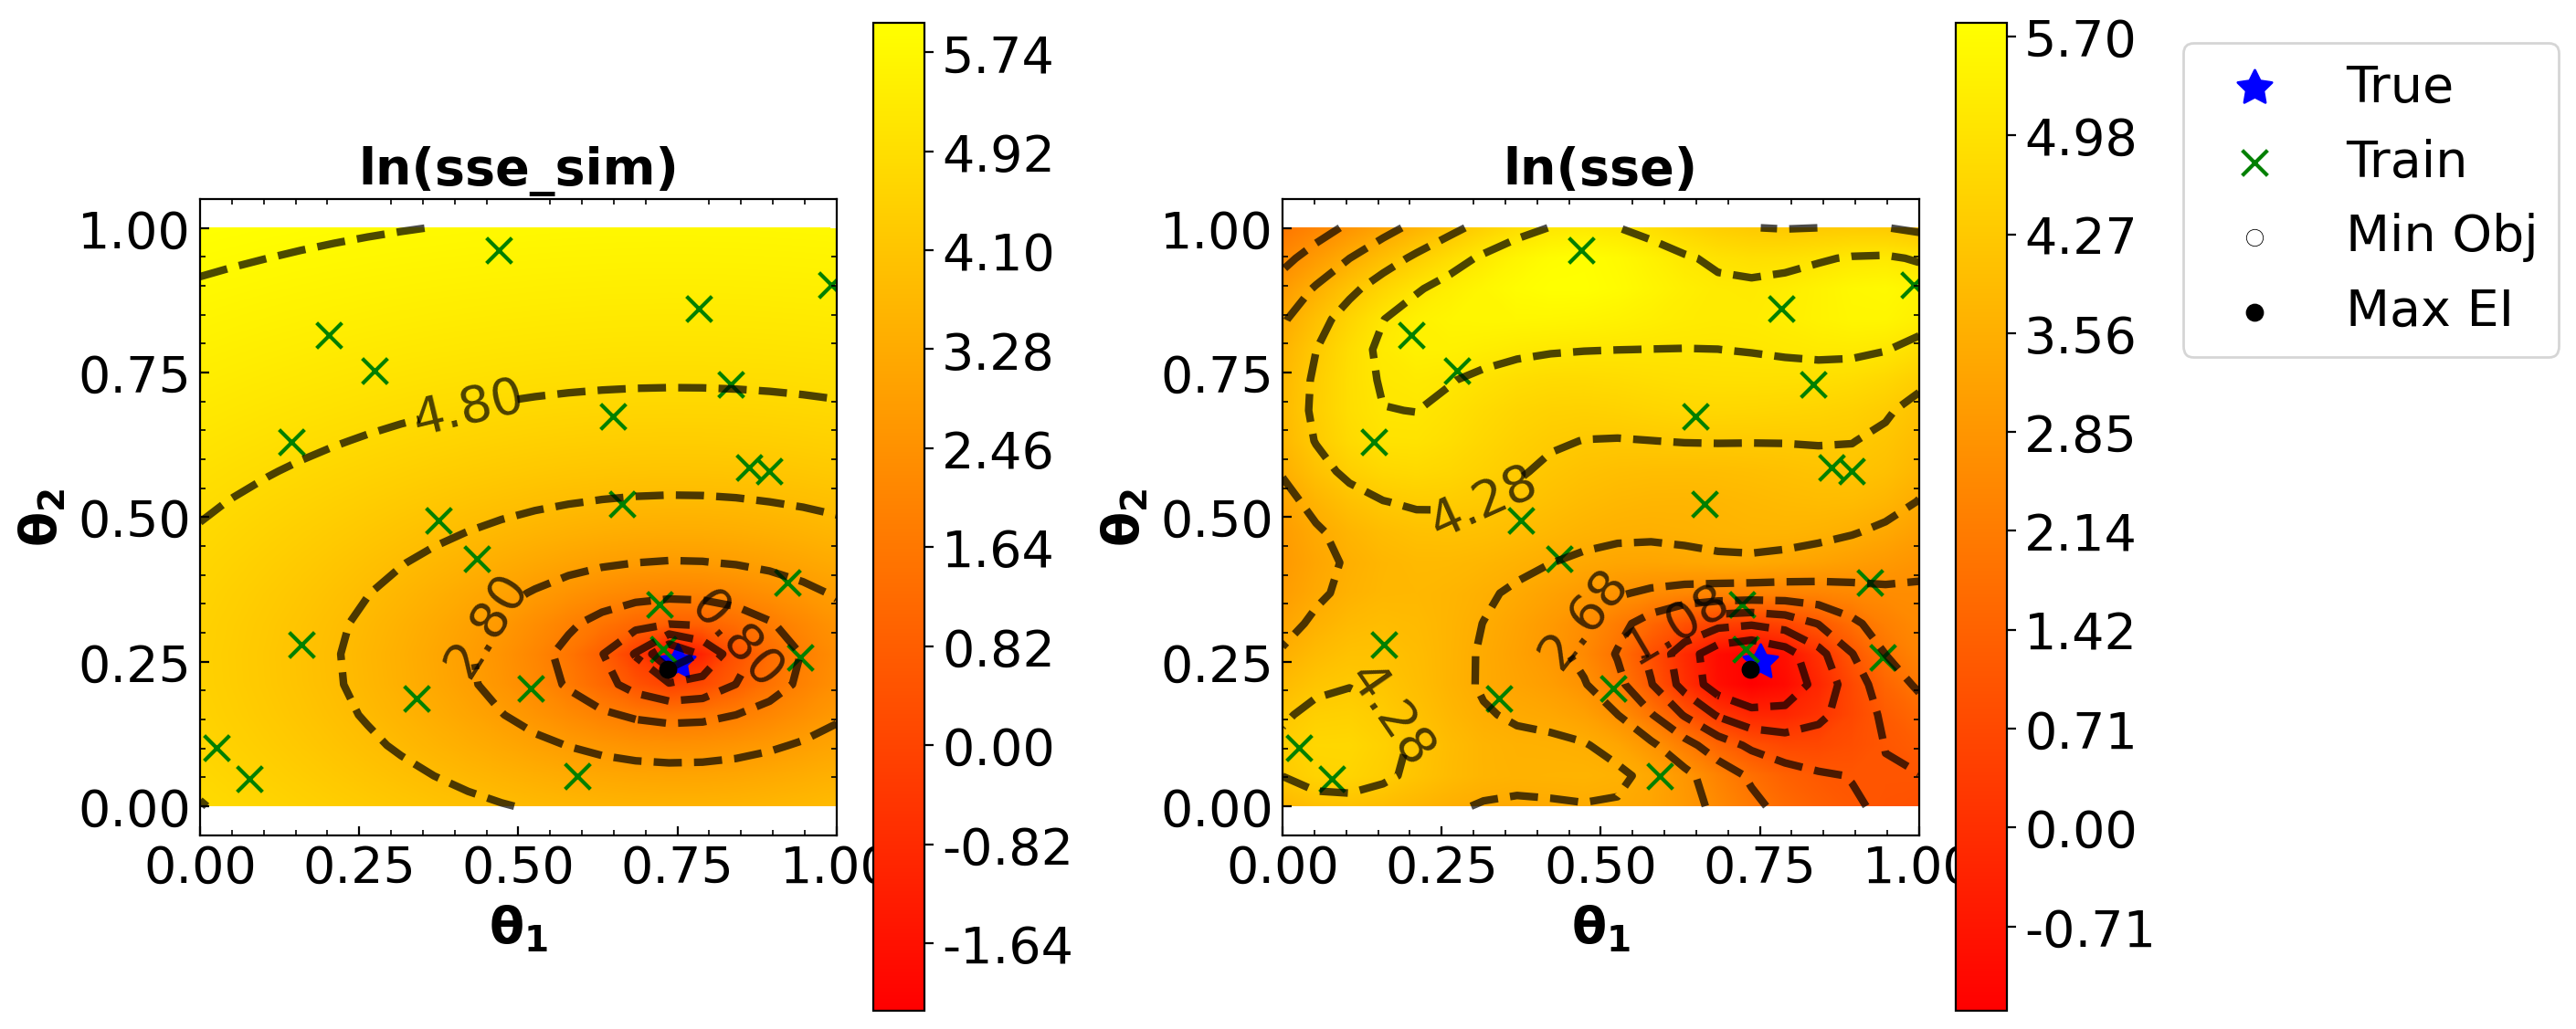

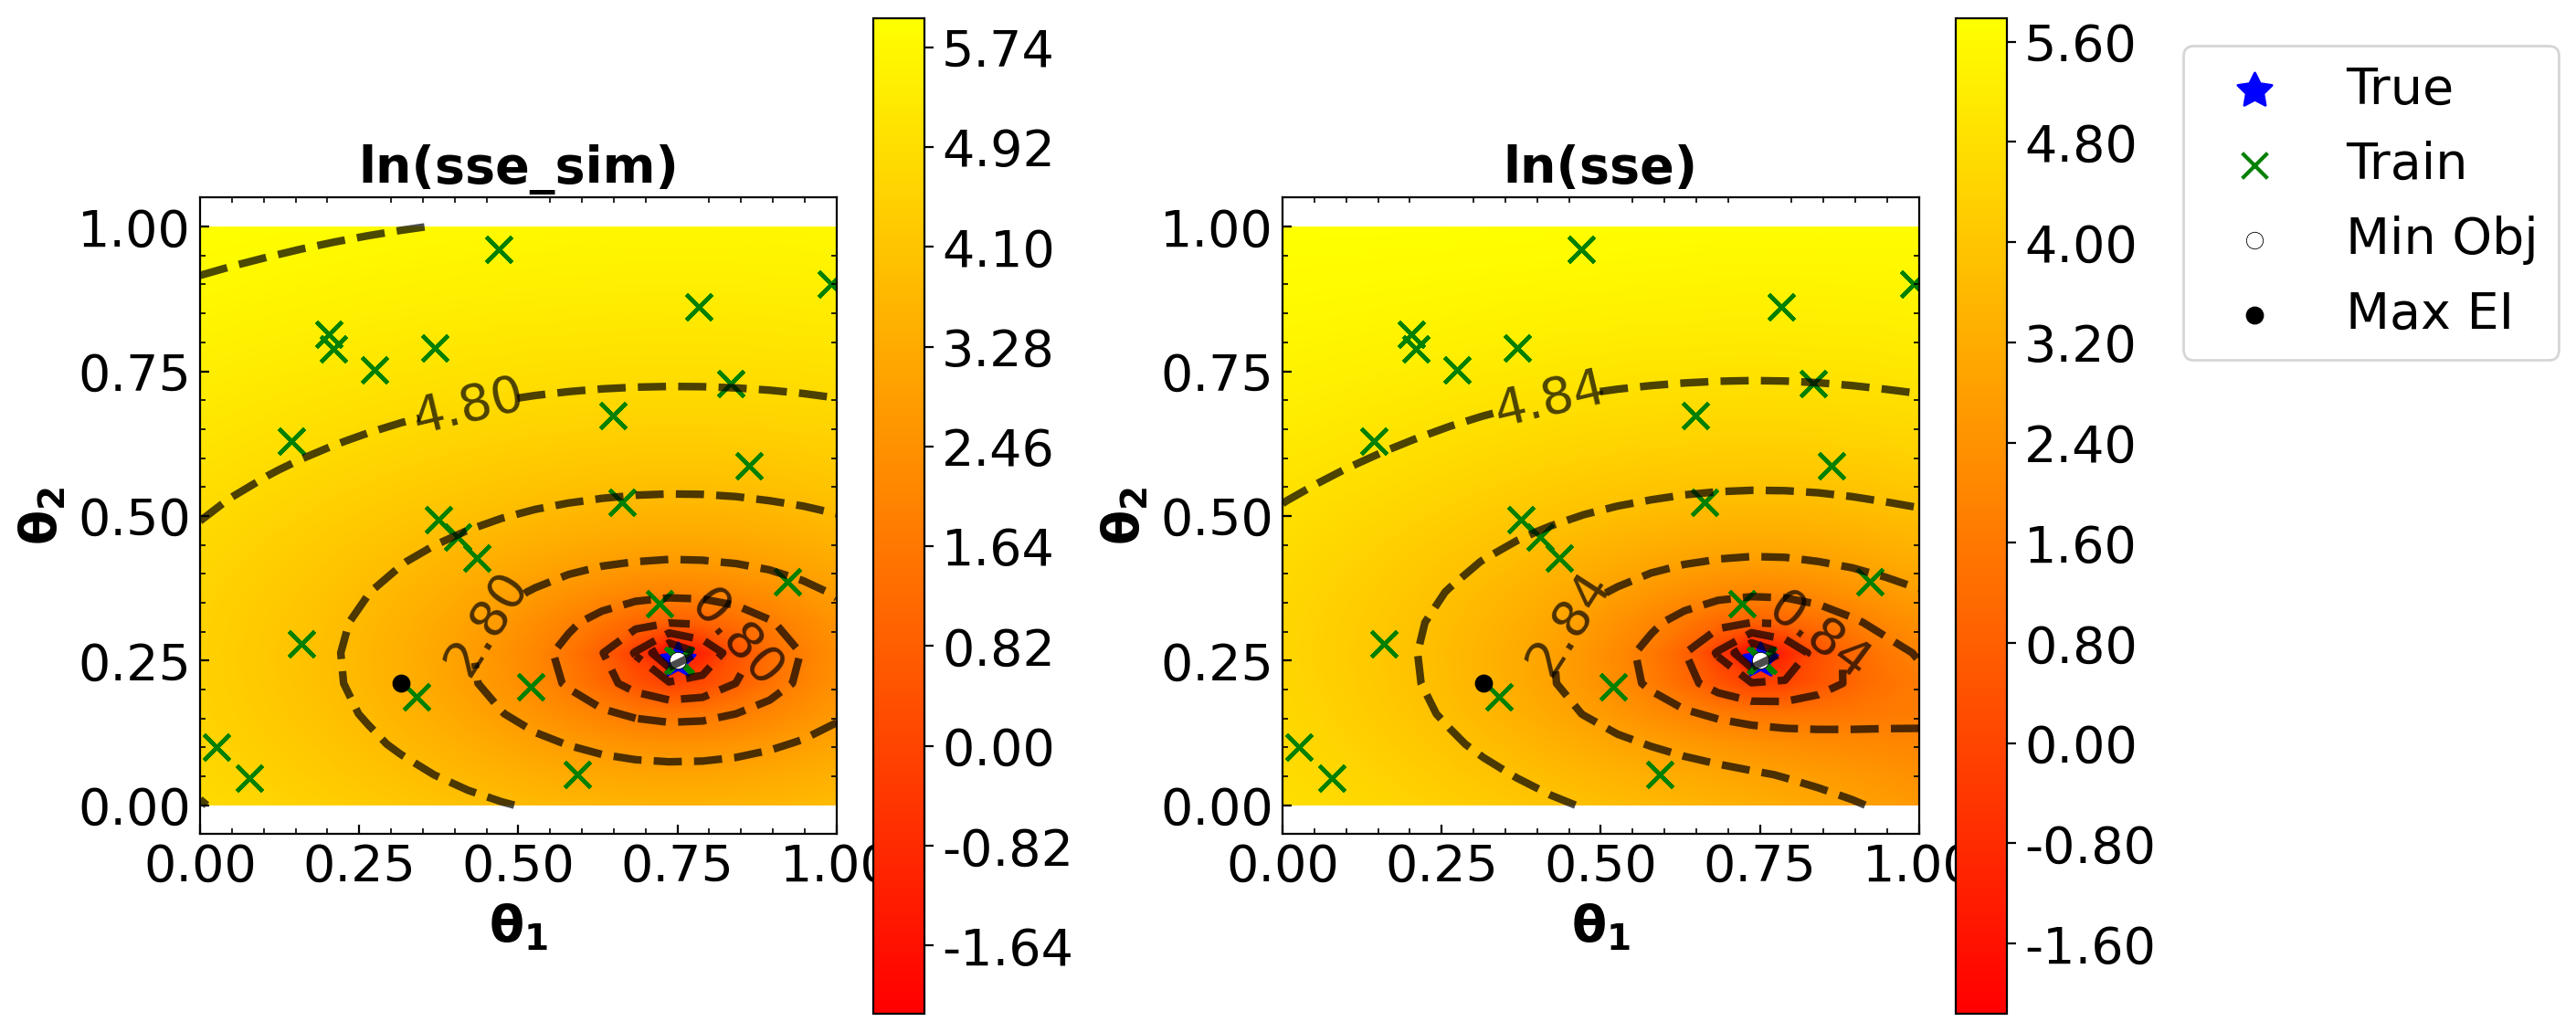

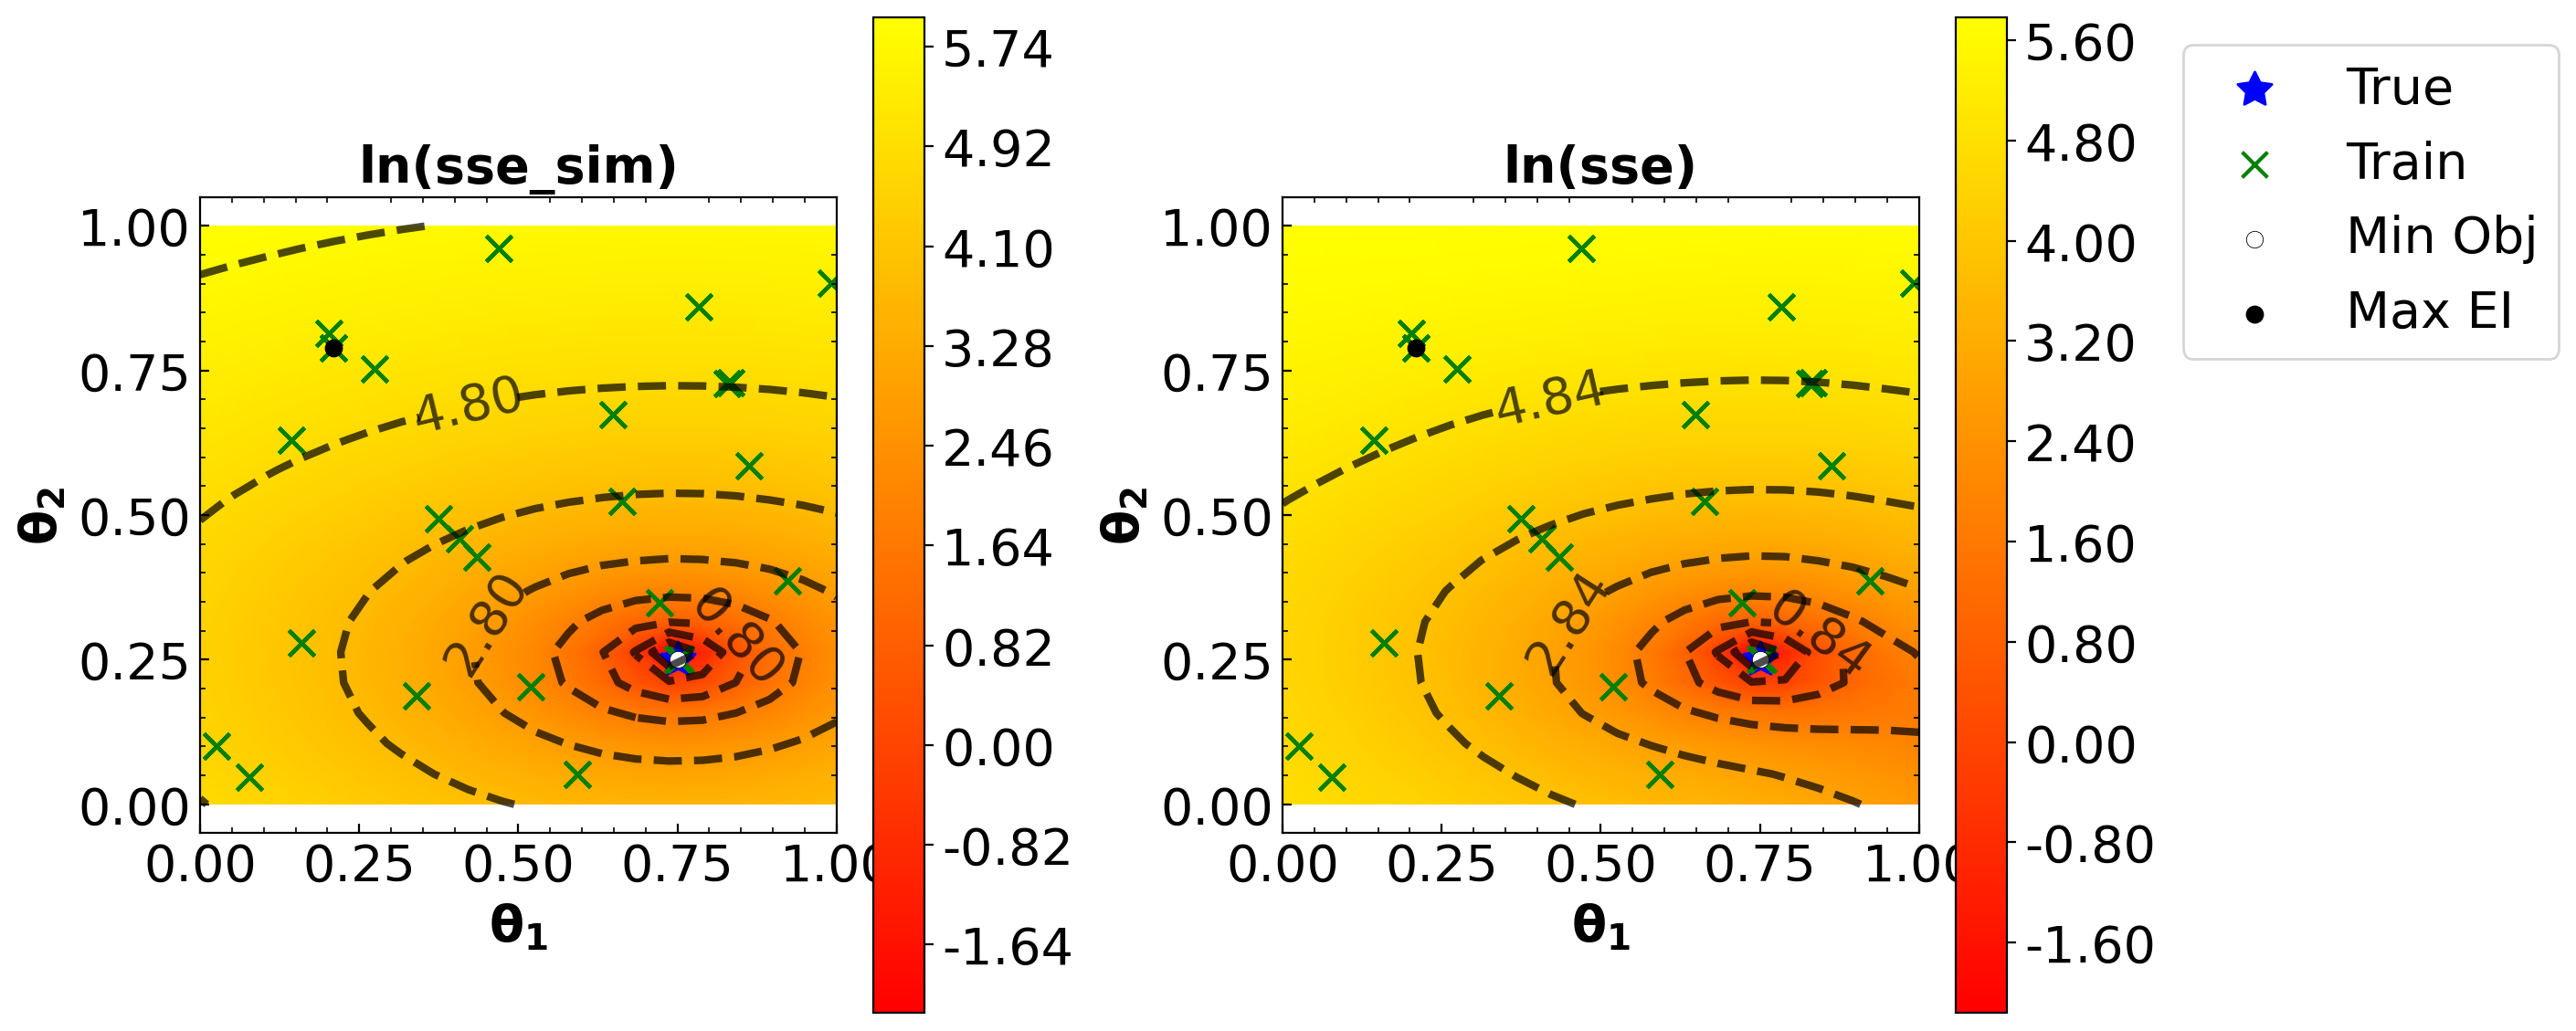

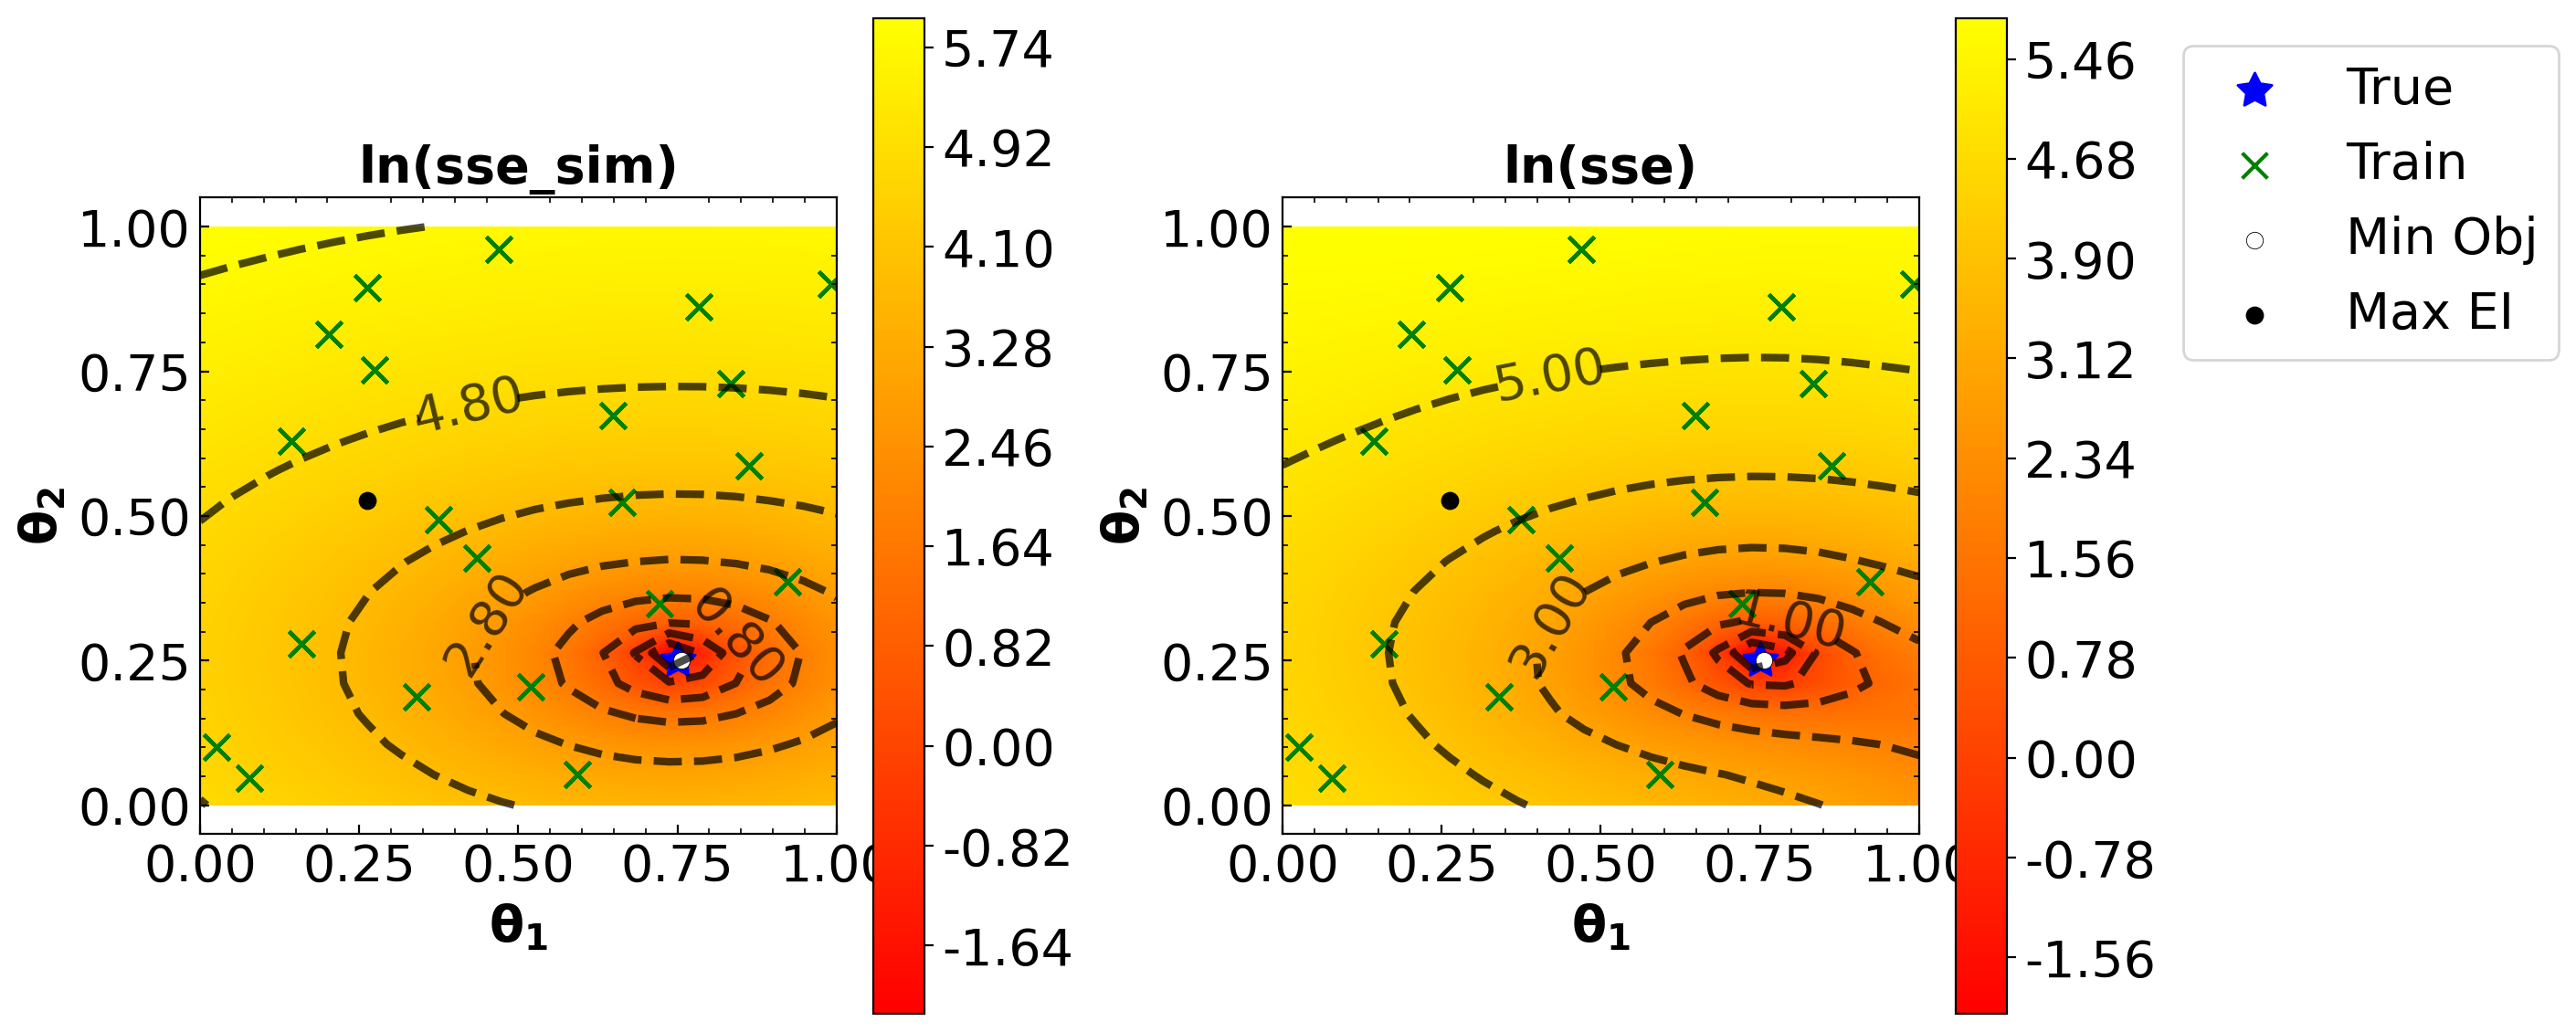

In [5]:
#Make heat maps
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_fig = False
cmap = "autumn"
log_data = True

#Get Best Data from ep experiment
df_best_path = job_list_best[0].fn("ep_study_best_all.csv")
df_best = pd.read_csv(df_best_path, header = 0, index_col = 0)

run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))
meth_names = list(df_best["BO Method"])

for i in range(len(job_list_best)):    
    run_num = run_num_list[i]
    bo_iter = bo_iter_list[i]
    file_path = job_list_best[i].fn("BO_Results.gz")
    string_val = df_best["Theta Min Obj"].iloc[0]
    numbers = [float(num) for num in string_val.replace('[', '').replace(']', '').split()]
    dim_theta = np.array(numbers).reshape(-1, 1)
    dim_theta = len(dim_theta)
    dim_list = np.linspace(0, dim_theta-1, dim_theta)
    pairs = len((list(combinations(dim_list, 2))))
    pair = 0
    
    get_ei = False
    analysis_list = analyze_heat_maps(file_path, run_num, bo_iter, pair, log_data, get_ei)
    sim_sse_var_ei, test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, idcs_to_plot = analysis_list
    sse_sim, sse_mean, sse_var, ei = sim_sse_var_ei

    title = "Heat Map Pair " + "-".join(map(str, plot_axis_names))
    title = None
#     z = [sse_sim, sse_mean, sse_var, ei]
#     z_titles = ["ln(sse_sim)", "ln(sse)", "ln(sse_var)", "log(ei)"]
#     levels = [100,100,100, 100]
    z = [sse_sim, sse_mean]
    z_titles = ["ln(sse_sim)", "ln(sse)"]
    levels = [100,100]
#     z = [sse_mean]
#     z_titles = [meth_names[i] + " log("+ r"$\mathbf{e(\theta)}$" + ")"]
    
    
    save_path = job_list[i].fn("")
    
    if save_fig == False:
        save_path = None

    plot_heat_maps(test_mesh, theta_true, theta_opt, theta_next, train_theta, plot_axis_names, levels, idcs_to_plot, 
                   z, z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)

In [7]:
#Plot Muller potential
project = signac.get_project()
meth_name_str_list = [1, 2, 3, 4, 5]
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] 
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 20
    theta_choice = None
    if loaded_results[0].configuration["Normalize"] == True:
        theta_true = loaded_results[run_num-1].simulator_class.theta_true_norm
    else:
        theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true #Note: Normalize theta_true for normalized data 
    #Note: Use normalized values for normalized data
#     theta_choice = np.array([-0.12334013, -1.97193209, -9.58736122,  0.70718457]) #(CS2_4 a 2A Set HPs)
#     theta_choice = np.array([-1.25179735, -1.30799798, -6.38989644,  0.69741102]) #(CS2_4 a 2A Trained HPs)   
#     theta_choice = np.array([-1.52838065,  0.76858661, -8.32826196, -0.15766997]) #(CS2_4 a 2C Set HPs)
#     theta_choice = np.array([-0.002612917, 0.493312186, 1.491001765, 0.999614708])  #(CS2_4 y0 2A Trained HPs) 
#     theta_choice = np.array([ 0.9346134,  -0.14312267,  0.65663397, -1.46321351])  #(CS2_4 y0 2C Trained HPs) 

    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

#     z = [y_sim]
#     z_titles = ["y_sim"]
    
    z = [y_sim,  gp_mean, gp_var]
#     print(np.min(y_sim), np.max(y_sim))
    z_titles = ["y_sim" , "y_gp", "y_var"]
    
    cmap = "jet"
    integer = 200
    levels = [integer,integer,integer]
    plot_axis_names = ["X1", "X2"]
#     try:
#         plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
#                    z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)
#     except:
#         pass
# print("Max EI Theta", theta_choice)

Method:  A1
Run Number:  2
BO Iter Number:  0
Trained Hyperparameters:  [array([0.517419  , 0.17940901]), 0.0001, 1]


ValueError: cannot reshape array of size 20 into shape (20,20,newaxis)